In [45]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(edgeitems=4, threshold=20)

In [32]:
u = np.array([-2, -3])

x = cp.Variable(2)
P = np.array([[2, -1], [-1, 4]])
q = np.array([-1, 0])
obj = cp.Minimize(0.5 * cp.quad_form(x, P, assume_PSD=True) + q @ x)

A = np.array([[1, 2], [1, -4], [5, 76]])
b = np.concatenate((u, [1]))
cons = [A @ x <= b]

prob = cp.Problem(obj, cons)
prob.solve()
prob.status, prob.value, x.value

('optimal', np.float64(8.222222222222221), array([-2.33333333,  0.16666667]))

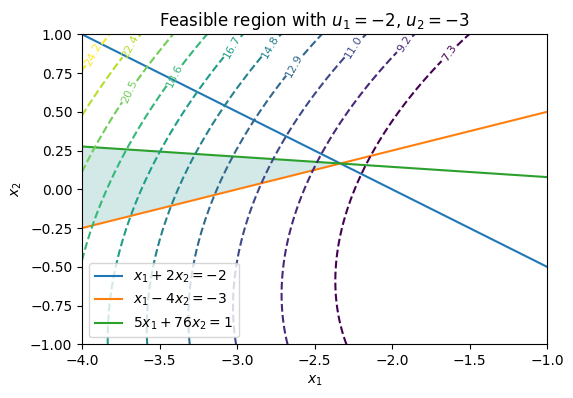

In [44]:
# updated parameters
u1, u2 = u[0], u[1]

x1 = np.linspace(-4, -1, 500)  # widen the domain in x₁
x2 = np.linspace(-1, 1, 500)
X1, X2 = np.meshgrid(x1, x2)

F = X1**2 + 2 * X2**2 - X1 * X2 - X1

c1 = X1 + 2 * X2 <= u1
c2 = X1 - 4 * X2 <= u2
c3 = 5 * X1 + 76 * X2 <= 1
feasible = c1 & c2 & c3  # logical AND

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(X1, X2, feasible, levels=[0.5, 1.1], alpha=0.20)

xx = np.linspace(-4, -1, 500)
ax.plot(xx, (u1 - xx) / 2, label=r"$x_1 + 2x_2 = -2$")
ax.plot(xx, (xx - u2) / 4, label=r"$x_1 - 4x_2 = -3$")
ax.plot(xx, (1 - 5 * xx) / 76, label=r"$5x_1 + 76x_2 = 1$")

levels = np.linspace(np.min(F[feasible]) - 1, np.max(F[feasible]) + 3, 10)
CS = ax.contour(X1, X2, F, levels=levels, linestyles="dashed")
ax.clabel(CS, fmt="%.1f", fontsize=8)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("Feasible region with $u_1=-2$, $u_2=-3$")
ax.legend()
ax.set_aspect("equal", "box")
plt.show()

Check KKT conditions


In [43]:
x_star = x.value
lam_star = cons[0].dual_value

primal_feasible = np.allclose(A @ x_star - b, 0)
dual_feasible = np.all(lam_star >= 0)
comp_slackness = np.allclose(lam_star * (A @ x_star - b), 0)
stationarity = np.allclose(x_star, -np.linalg.inv(P) @ (A.T @ lam_star + q))
kkt = primal_feasible and dual_feasible and comp_slackness and stationarity

primal_optimal = prob.value
P_inv = np.linalg.inv(P)
dual_optimal = -0.5 * (A.T @ lam_star + q) @ P_inv @ (A.T @ lam_star + q) - b @ lam_star
strong_duality = np.allclose(primal_optimal, dual_optimal)

kkt, strong_duality

(True, True)

In [39]:
lam_star, (A @ x_star - b)

(array([2.74774125, 2.88523345, 0.04007173]),
 array([4.4408921e-16, 0.0000000e+00, 4.4408921e-15]))

Part (b): perturbed QP


In [60]:
data = []
for delta1 in [0, -0.1, 0.1]:
    for delta2 in [0, -0.1, 0.1]:
        u1 = u[0] + delta1
        u2 = u[1] + delta2
        prediction = primal_optimal - lam_star[0] * delta1 - lam_star[1] * delta2
        b = np.concatenate((np.array([u1, u2]), [1]))
        cons = [A @ x <= b]
        prob = cp.Problem(obj, cons)
        prob.solve()
        data.append(
            {
                "delta1": delta1,
                "delta2": delta2,
                "predicted": round(prediction, 4),
                "exact": round(prob.value, 4),
                "percent_error": round(
                    100 * abs(prediction - prob.value) / prob.value, 1
                ),
                "pred <= exact": prediction <= prob.value,
            }
        )

In [61]:
df_data = pd.DataFrame(data)
df_data

,delta1,delta2,predicted,exact,percent_error,pred <= exact
0,0.0,0.0,8.2222,8.2222,0.0,True
1,0.0,-0.1,8.5107,8.7064,2.2,True
2,0.0,0.1,7.9337,7.9800,0.6,True
3,-0.1,0.0,8.4970,8.5650,0.8,True
4,-0.1,-0.1,8.7855,8.8156,0.3,True
5,-0.1,0.1,8.2085,8.3189,1.3,True
6,0.1,0.0,7.9474,8.2222,3.3,True
7,0.1,-0.1,8.2360,8.7064,5.4,True
8,0.1,0.1,7.6589,7.7515,1.2,True
